# 1.下載台股大盤資料

In [2]:

import io
import requests
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def crawl_price(stock_id):
    now = int(datetime.datetime.now().timestamp())+86400
    url = "https://query1.finance.yahoo.com/v7/finance/download/" + stock_id + "?period1=0&period2=" + str(now) + "&interval=1d&events=history&crumb=hP2rOschxO0"

    response = requests.post(url)

    f = io.StringIO(response.text)
    df = pd.read_csv(f, index_col='Date', parse_dates=['Date'] )

    return df


twii = crawl_price("^TWII")
twii.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-07-02,9094.269531,9124.299805,8988.129883,8996.719727,8996.686523,0.0
1997-07-03,9061.599609,9061.599609,8997.509766,9027.629883,9027.596680,0.0
1997-07-04,9144.959961,9218.209961,9119.250000,9192.570313,9192.536133,0.0
1997-07-07,9365.190430,9370.410156,9304.820313,9322.839844,9322.805664,0.0
1997-07-08,9345.549805,9371.500000,9282.099609,9305.269531,9305.235352,0.0


# 2.編寫台股sharpe ratio

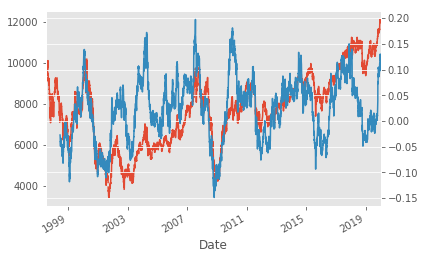

In [3]:
mean = twii['Adj Close'].pct_change().rolling(252).mean()
std = twii['Adj Close'].pct_change().rolling(252).std()

sharpe = mean / std

twii.Close.plot()
sharpe.plot(secondary_y=True)


# 3.編寫台股sharpe ratio策略

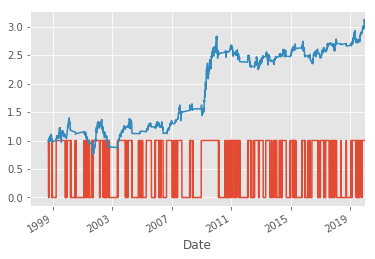

In [4]:


import numpy as np
# sharpe ratio 平滑
sr = sharpe
srsma = sr.rolling(60).mean()

# sharpe ratio 的斜率
srsmadiff = srsma.diff()

# 計算買入賣出點
buy = (srsmadiff > 0) & (srsmadiff.shift() < 0)
sell = (srsmadiff < 0) & (srsmadiff.shift() > 0)

# 計算持有時間
hold = pd.Series(np.nan, index=buy.index)
hold[buy] = 1
hold[sell] = 0
hold.ffill(inplace=True)
hold.plot()

# 持有時候的績效
adj = twii['Adj Close'][buy.index]
(adj.pct_change().shift(-1)+1).fillna(1)[hold == 1].cumprod().plot()


# 4.參數最佳化

In [5]:

def backtest(a, b, c, d):
    sr = sharpe
    srsma = sr.rolling(a).mean()

    srsmadiff = srsma.diff() * 100
    ub = srsmadiff.quantile(b)
    lb = srsmadiff.quantile(c)
    
    buy = ((srsmadiff.shift(d) < lb) & (srsmadiff > ub))
    sell = ((srsmadiff.shift(d) > ub) & (srsmadiff < lb))

    hold = pd.Series(np.nan, index=buy.index)
    hold[buy] = 1
    hold[sell] = 0

    hold.ffill(inplace=True)
    
    adj = twii['Adj Close'][buy.index]

    # eq = (adj.pct_change().shift(-1)+1).fillna(1)[hold == 1].cumprod().plot()
    # hold.plot()
    eq = (adj.pct_change().shift(-1)+1).fillna(1)[hold == 1].cumprod()
    if len(eq) > 0:
        return eq.iloc[-1]
    else:
        return 1


backtest(252,0.4,0.6,4)	


1.3631292922312845

# 參數枚舉優化

In [6]:
maxeq = 0

for a in range(100,200,20):
    for b in np.arange(0.3, 0.9, 0.03):
        for c in np.arange(0.3, 0.6, 0.03):
            for d in range(60, 180, 10):
                
                eq = backtest(a,b,c,d)
                
                if maxeq < eq:
                    maxeq = eq
                    print(eq, a,b,c,d)


2.0573786082960073 100 0.3 0.3 60
2.099345283883081 100 0.3 0.3 70
2.59363497558073 100 0.3 0.3 160
2.685818861168172 100 0.3 0.4199999999999999 160
2.6860575162024922 100 0.3 0.44999999999999984 160
2.862291614285433 100 0.3 0.44999999999999984 170
3.151671164412486 100 0.3 0.4799999999999998 160
3.245871574714858 100 0.3 0.5399999999999998 170
3.268817711245045 100 0.32999999999999996 0.5399999999999998 170
3.305412264188395 100 0.35999999999999993 0.4799999999999998 160
3.553505443799107 100 0.35999999999999993 0.5399999999999998 170
3.7037842238533982 100 0.4199999999999999 0.5699999999999997 60
3.730918794219269 100 0.6599999999999997 0.35999999999999993 140
3.8029097903171776 100 0.6599999999999997 0.35999999999999993 150
3.9806674986700545 100 0.6599999999999997 0.3899999999999999 150
4.054220545290538 100 0.6599999999999997 0.44999999999999984 150
4.296367360012891 100 0.6599999999999997 0.44999999999999984 170
4.336179208624379 100 0.6599999999999997 0.4799999999999998 150
4.8

In [7]:
backtest(100,0.6899999999999996,0.4799999999999998,150)

5.4154830180526865